# 0 - IMPORTS AND FUNCTIONS

In [1]:
# Data Analysis and Data Manipulation Libraries
import inflection
import joblib
import pandas                                       as pd
import numpy                                        as np
import seaborn                                      as sns
import scikitplot                                   as skplt
import plotly.express                               as px
import plotly.graph_objects                         as go
from matplotlib              import pyplot          as plt

# Data Processing
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing   as pp
from sklearn.model_selection import KFold

import optuna

# ML Models and Metrics
import lightgbm                                         as lgbm

from catboost                import CatBoostClassifier
from xgboost                 import XGBClassifier
from sklearn.metrics         import precision_score 
from sklearn.metrics         import precision_recall_curve
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

# Dysplay
%matplotlib inline
from IPython.core.display    import HTML
from IPython.display         import Image

import warnings
warnings.filterwarnings( 'ignore' )

### 0.1 - HELPER FUNCTIONS

In [87]:
def test_prep(dfte):
    ######## TEST DATASET ############
    ## Renaming Columns
    cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase','Store size', 'Store distance', 'InStore wifi',
                'Open/Close time convenient', 'Easy of online shopping', 'Store location', 'Toilet cleaning', 'Dressing room', 
                'Waiting room','Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store', 'Purchase service', 
                'Store Service', 'Cleanliness', 'Carrier delay in minutes', 'Delivery delay in minutes']

    snakecase = lambda x: inflection.underscore(x.replace(' ', '_'))
    cols_new = list( map( snakecase, cols_old ) )

    dfte.columns = cols_new
    
    # Fill NaN
    dfte['delivery_delay_in_minutes'] = dfte['delivery_delay_in_minutes'].fillna(dfte['carrier_delay_in_minutes'])

    
    # TRANSFORMERS
    
    fe_gender    = joblib.load( 'fe_gender.joblib')
    fe_tpurchase = joblib.load( 'fe_tpurchase.joblib')
    oe_customer  = joblib.load( 'oe_customer.joblib')
    oe_store     = joblib.load( 'oe_store_size.joblib')
    mm_age       = joblib.load( 'mms_age.joblib')
    rs_stored    = joblib.load( 'rs_stored.joblib')
    
    # gender
    dfte['gender'] = dfte['gender'].map(fe_gender)
    
    # type_of_purchase
    dfte['type_of_purchase'] = dfte['type_of_purchase'].map( fe_tpurchase )

    # distance
    dfte['customer_type'] =oe_customer.transform(dfte[['customer_type']].values)

    # Store Size
    dfte['store_size'] = oe_store.transform(dfte[['store_size']].values)

    # REESCALING
 
    # age
    dfte['age'] = mm_age.transform(dfte[['age']].values)

    # Store Distance
    dfte['store_distance'] = rs_stored.transform(dfte[['store_distance']].values)

    # TRANSFORMACAO LOGARITMICA 
    
    # carrier_delay_in_minutes
    dfte['carrier_delay_in_minutes'] = dfte['carrier_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x) 

    # delivery_delay_in_minutes
    dfte['delivery_delay_in_minutes'] = dfte['delivery_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x) 

    return(dfte)

def cross_validation(kfold, modelName, model, X, y):
    
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    
    for train_cv,val_cv in fold.split(X, y):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = X.iloc[train_cv]
        x_train_fold = x_train_fold
        
        y_train_fold = y.iloc[train_cv]
        y_train_fold = y_train_fold
        
        # validation data
        x_val_fold = X.iloc[val_cv]
        x_val_fold = x_val_fold
        
        y_val_fold = y.iloc[val_cv]
        y_val_fold = y_val_fold
        
        # fitting the model
        model_fitted = model.fit(x_train_fold, y_train_fold)
        
        # predict
        yhat = model_fitted.predict(x_val_fold)
        
        #performance
        precision = precision_score(y_val_fold, yhat, average='micro')
        precision_list.append(precision)
        
    return np.mean(precision_list)

def plot_scores(param_name, param_range, fixed_params, clf_model, X_train, y_train, X_val, y_val):
    
    train_scores = []
    val_scores = []
    
    for param_value in param_range:
        params = fixed_params
        params[param_name] = param_value
        
        model = clf_model(**params)
        model.fit(X_train, y_train)
        
        train_scores.append(precision_score(y_train, model.predict(X_train)))
        val_scores.append(precision_score(y_val, model.predict(X_val)))
    
    plt.figure(figsize=(8, 4))
    plt.plot(param_range, train_scores, label="Train", color="#264653", marker='o')
    plt.plot(param_range, val_scores, label="Val", color="#e76f51", marker='o')

    plt.title("LightGBM")
    plt.xlabel(param_name)
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.legend(loc="best");

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
   
    sns.set()
jupyter_settings()

# 1 - DATA EXTRACTION

In [74]:
# All Data - Windows
df_raw = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/InStyle_Net_Promoter_Score/data/train.csv')

In [4]:
## Renaming Columns
cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase','Store size', 'Store distance', 'InStore wifi',
            'Open/Close time convenient', 'Easy of online shopping', 'Store location', 'Toilet cleaning', 'Dressing room', 
            'Waiting room','Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store', 'Purchase service', 
            'Store Service', 'Cleanliness', 'Carrier delay in minutes', 'Delivery delay in minutes', 'Satisfaction']

snakecase = lambda x: inflection.underscore(x.replace(' ', '_'))
cols_new = list( map( snakecase, cols_old ) )

df_raw.columns = cols_new

In [5]:
df1 = df_raw.copy()

### 1.1 - Data Descriptive

In [ ]:
#prof = ProfileReport(df_raw)
#prof.to_file(output_file='data_descriptive.html')

In [ ]:
# Data Dimensions
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

In [ ]:
# Data Types
df1.dtypes

In [ ]:
# Verifying if there are NaN values
df1.isna().sum()

There are 310 missing values for the variable delivery_delay_in_minutes. The decision made is to fill the NaN values with the correspondent value on the column carrier_delay_in_minutes, because were noticed that when the carrier is 0, the delay is also 0, and around 50% of the NaN is 0 for carrier_delay.

In [ ]:
# Analyze and Fill NaN
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].fillna(df1['carrier_delay_in_minutes'])

### 1.1.1 - Distribuition Analysis

In [ ]:
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

# 2 - FEATURE ENGINEERING

In [6]:
df2 = df1.copy()

# 3. DATA FILTERING

In [7]:
df3 = df2.copy()

# 4. EDA

In [8]:
df4_eda = df3.copy()

## 4.1 Univariate Analysis

### Numerical Attributes

In [ ]:
columns_to_plot = num_attributes.columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)

#Usar o divmod para encontrar os axes 
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    #plotar todos os boxplots
    sns.boxplot(df1, x=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

### Categorical Attributes

In [ ]:
labels = cat_attributes.columns
label = 'satisfaction'

In [ ]:
plt.figure(figsize=(14, len(labels) * 2))

for i, col in enumerate(labels):
    plt.subplot(len(labels) // 2 + 1, 3, i + 1)
    sns.countplot(x=col, hue=label, data=df1)
    plt.title(f"{col} vs {label}")
    plt.tight_layout()

## 4.2 Bivariate Analysis

In [ ]:
print(px.colors.qualitative.Plotly)

In [ ]:
# 1 - As the dressing room score increases, the volume of dissatisfied customers decreases.
# Hyphotesis is true.
aux = df4_eda[['id','dressing_room','satisfaction']].groupby(['dressing_room','satisfaction']).count().reset_index()
fig = px.bar(aux, x="dressing_room", y="id",
             color='satisfaction',
             barmode='group',
             text='id',
             color_discrete_sequence=['mediumturquoise', 'lightgreen'],
             height=600,
             width=1000)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')

fig.update_layout(uniformtext_minsize=8, 
                  uniformtext_mode='hide',
                  title={ 'text':'Dressing Room Score vs Customer Satisfaction', 'x':0.45, 'y':0.95},
                  plot_bgcolor='white',
                  paper_bgcolor='white')

fig.show()

In [ ]:
# 2 - As the toilet cleaning score increases, the volume of dissatisfied customers decreases.
aux = df4_eda[['id','toilet_cleaning','satisfaction']].groupby(['toilet_cleaning','satisfaction']).count().reset_index()
fig = px.bar(aux, x="toilet_cleaning", y="id",
             color='satisfaction',
             barmode='group',
             text='id',
             color_discrete_sequence=['mediumturquoise', 'lightgreen'],
             height=600,
             width=1000)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')

fig.update_layout(uniformtext_minsize=8, 
                  uniformtext_mode='hide',
                  title={ 'text':'Toilet Cleaning Score vs Customer Satisfaction', 'x':0.45, 'y':0.95},
                  plot_bgcolor='white',
                  paper_bgcolor='white')

fig.show()

In [ ]:
# 3 - Clientes homens sao em geral, mais satisfeitos que clientes mulheres.

aux2 = pd.crosstab(df4_eda['gender'], df4_eda['satisfaction'])
aux2['percentage'] = aux2['Neutral or Dissatisfaction']/(aux2['Neutral or Dissatisfaction']+aux2['Satisfied'])

colors = ['mediumturquoise', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels= ['Neutral or Dissatisfaction', 'Satisfied'], values= [57, 56])])

fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))


fig.update_layout(uniformtext_minsize=8, 
                  uniformtext_mode='hide',
                  title={ 'text':'Percent. of Gender vs Customer Satisfaction', 'x':0.40, 'y':0.95},
                  height=600,  # Adjust the height as needed
                  width=1000    # Adjust the width as needed
                  )
fig.show()

In [ ]:
# 4 - The larger the store, the more satisfied its customers tend to be.
aux1 = df4_eda[['id','store_size','satisfaction']].groupby(['store_size','satisfaction']).count().reset_index()

fig = px.bar(aux1, x="store_size", y="id",
             color='satisfaction',
             barmode='group',
             text='id',
             color_discrete_sequence=['mediumturquoise', 'lightgreen'],
             height=600,
             width=1000)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')

fig.update_layout(uniformtext_minsize=8, 
                  uniformtext_mode='hide',
                  title={ 'text':'Store Size vs Customer Satisfaction', 'x':0.35, 'y':0.95},
                  plot_bgcolor='white',
                  paper_bgcolor='white')

fig.show()

In [ ]:
# Even unsatisfied customers are happy with the store service.
aux =df4_eda[['id','store_service','satisfaction']].groupby(['store_service','satisfaction']).count().reset_index()

fig = px.bar(aux, x="store_service", y="id",
             color='satisfaction',
             barmode='group',
             text='id',
             color_discrete_sequence=['mediumturquoise', 'lightgreen'],
             height=600,
             width=1000)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside')

fig.update_layout(uniformtext_minsize=8, 
                  uniformtext_mode='hide',
                  title={ 'text':'Store Service Score vs Customer Satisfaction', 'x':0.50, 'y':0.95},
                  plot_bgcolor='white',
                  paper_bgcolor='white')

fig.show()

## 4.3 Multivariate Analysis

In [ ]:
aux_43= num_attributes.copy()

mask = np.zeros_like(aux_43.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Correlation Matrix',fontsize=18)
sns.heatmap(aux_43.corr(),linewidths=0.25, fmt=".2f", cmap="Blues", linecolor='w', annot=True, annot_kws={"size":11}, mask=mask, cbar_kws={"shrink": .9});

# 5. DATA PREPARATION

In [62]:
df5 = df4_eda.copy()

In [63]:
# FREQUENCY ENCODER
# gender
fe_gender = df5.groupby('gender').size() / len(df5)
df5['gender'] = df5['gender'].map( fe_gender )
joblib.dump(fe_gender, 'fe_gender.joblib')

# type_of_purchase
fe_tpurchase = df5.groupby( 'type_of_purchase' ).size() / len( df5 ) 
df5['type_of_purchase'] = df5['type_of_purchase'].map( fe_tpurchase )
joblib.dump(fe_tpurchase, 'fe_tpurchase.joblib')

# ORDINAL ENCODER
oea = pp.OrdinalEncoder()
oeb = pp.OrdinalEncoder()

# distance
df5['distance'] = oea.fit_transform(df5[['distance']].values)
#joblib.dump(oe_distance, 'oe_distance.joblib')

# age_group
df5['age_group'] = oeb.fit_transform(df5[['age_group']].values)
#joblib.dump(oe_ageg, 'oe_ageg.joblib')

# distance
df5['customer_type'] = oea.fit_transform(df5[['customer_type']].values)
joblib.dump(oea, 'oe_customer.joblib')

# Store Size
df5['store_size'] = oeb.fit_transform( df5[['store_size']].values )
joblib.dump(oeb, 'oe_store_size.joblib')

# REESCALING
mms = pp.MinMaxScaler()

# age
df5['age'] = mms.fit_transform( df5[['age']].values )
joblib.dump(mms, 'mms_age.joblib')

# ROBUST SCALER
rs = pp.RobustScaler()

# Store Distance
df5['store_distance'] = rs.fit_transform( df5[['store_distance']].values )
joblib.dump(rs, 'rs_stored.joblib')

# TRANSFORMACAO LOGARITMICA 
# carrier_delay_in_minutes
df5['carrier_delay_in_minutes'] = df5['carrier_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x) 

# delivery_delay_in_minutes
df5['delivery_delay_in_minutes'] = df5['delivery_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x) 

# Response
# satisfaction
df5['satisfaction'] = df5['satisfaction'].apply(lambda x: 1 if x=='Satisfied' else 0)

# 6. FEATURE SELECTION

In [ ]:
df6 = df_raw.copy()
df6_prep = train_prep(df6)
feat_x = df6_prep.drop(['satisfaction'], axis=1)
feat_y = df6_prep['satisfaction'].copy() 

In [ ]:
# model definition
xgboost = XGBClassifier()

# model training
xgboost.fit(feat_x, feat_y)

In [ ]:
feature_importances = xgboost.feature_importances_
feature_names = feat_x.columns 
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)
plt.figure(figsize=(10, 10))

plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.show()

As this is the first cycle, we will consider all features for the model, but it is something that could be tested ont he new further cycles and see the impact on performance, resources, etc.

# 7. MACHINE LEARNING

In [11]:
df7 = df5.copy()

## 7.1 - DATASET SPLIT

In [12]:
# Dividindo o dataset em treino, validacao e teste
X = df7.drop( ['satisfaction'], axis=1 )
y = df7['satisfaction'].copy()

train_x, val_x, train_y, val_y   = ms.train_test_split( X, y, test_size=0.15, shuffle=True, random_state=None )
train_x, test_x, train_y, test_y   = ms.train_test_split( train_x, train_y, test_size=0.176475917, shuffle=True, random_state=None )
print(f" train_x: {train_x.shape}\n train_y: {train_y.shape}\n val_x: {val_x.shape}\n val_y: {val_y.shape}\n test_x: {test_x.shape}\n test_y: {test_y.shape}\n")

 train_x: (72731, 23)
 train_y: (72731,)
 val_x: (15586, 23)
 val_y: (15586,)
 test_x: (15587, 23)
 test_y: (15587,)



## 7.2 Machine Learning Models

The goal is to select the model that is cappable to classify/identify the highest number of dissatisfied customers. We are going to use two machine learning algorithms:
* Extreme Boosting Classifier

* Light Gradient Boosting Classifier

### 7.2.1 XGB

#### performance using cross_validation technique

In [13]:
clf_xgb = XGBClassifier()

evalxgb = cross_validation(5, 'XGB', clf_xgb, train_x, train_y)
evalxgb

0.9629456565688816

#### performance using train_test_val split

In [14]:
clf_xgb_one = XGBClassifier()

# model training
clf_xgb_one.fit( train_x, train_y )

# model prediction - Check if the model perform well
yhat_xgb_one = clf_xgb_one.predict( val_x )

# Evaluation
precision_score(val_y, yhat_xgb_one, average='micro') 

0.9660592839727961

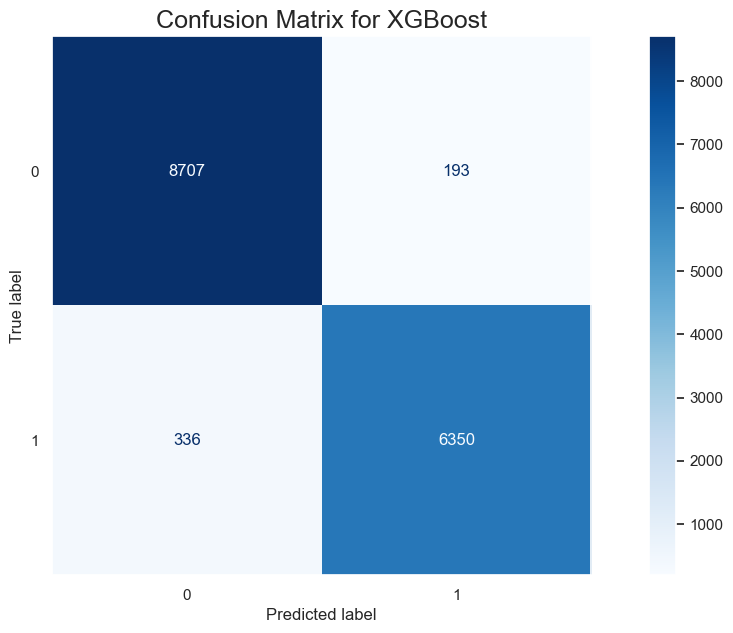

In [15]:
cm_xgb = confusion_matrix(val_y, yhat_xgb_one, labels=clf_xgb_one.classes_)
cm_xgb_disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=clf_xgb_one.classes_)
cm_xgb_disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix for XGBoost', fontsize=18)
plt.grid(False)
plt.gca().set_facecolor('white')

plt.show()

* 0 represents Neutral or Dissatisfaction

* 1 represents Satisfied

The metric selected is precision, that evaluate the proportion of correct predictions made considering the true label (Satisfied Customers).

### 7.2.2 LGBM

#### performance using cross_validation technique

In [16]:
clf_lgbm = lgbm.LGBMClassifier(verbose=-1)

evallgbm = cross_validation(5, 'LGBM', clf_lgbm, train_x, train_y)
evallgbm

0.9636468405755745

#### performance using train_test_val split technique

In [17]:
clf_lgbm_one = lgbm.LGBMClassifier(verbose=-1)

# model training
clf_lgbm_one.fit( train_x, train_y )

# model prediction - Check if the model perform well
yhat_lgbm_one = clf_lgbm_one.predict( val_x )

# Evaluation
precision_score(val_y, yhat_lgbm_one, average='micro') 

0.9667008854099833

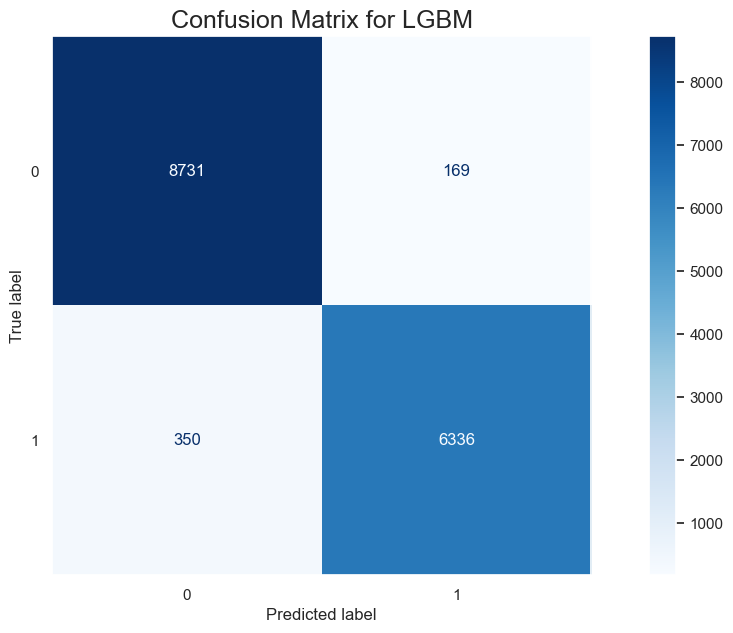

In [18]:
cm_lgbm = confusion_matrix(val_y, yhat_lgbm_one,  labels = clf_lgbm_one.classes_)
cm_lgbm_disp = ConfusionMatrixDisplay(confusion_matrix = cm_lgbm,
                                      display_labels = clf_lgbm_one.classes_,
                                     )

cm_lgbm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LGBM', fontsize=18)
plt.grid(False)
plt.gca().set_facecolor('white')

plt.show()

# 8. FINE TUNING

The hyperparameteres were selected using two techniques:

* Optuna: with is a bysean search technique.

* Manualy setting some parameters after optuna selection.

## 8.1 XGB

In [ ]:
# def objective_xgb(trial):
#     """Define the objective function"""

#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'eta': trial.suggest_float('eta', 0.01, 0.05),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'eval_metric': 'mlogloss',
#         'use_label_encoder': False
#     }

#     # Fit the model
#     optuna_xgb = XGBClassifier(**params)
#     optuna_xgb.fit(x_train, y_train)

#     # Make predictions
#     optuna_xgb_pred = optuna_xgb.predict(test_x)

#     # Evaluate predictions
#     precision = precision_score(test_y, optuna_xgb_pred, average='micro')
#     return precision

In [ ]:
# %%time
# study_xgb = optuna.create_study(direction='maximize')
# study_xgb.optimize(objective_xgb, n_trials=150)

In [ ]:
# print('Number of finished trials: {}'.format(len(study_xgb.trials)))
# print('Best trial:')
# trial = study_xgb.best_trial

# print('  Value: {}'.format(trial.value))
# print('  Params: ')

# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [ ]:
# fig = optuna.visualization.plot_slice(study_xgb, params=["learning_rate", "max_depth", "n_estimators"])#, "reg_alpha", "reg_lambda"])
# fig.show()

In [19]:
params_xgb = {
    'max_depth': 12,
    'eta': 0.019834339603301256,
    'learning_rate': 0.011,
    'n_estimators': 450,
    'min_child_weight': 2,
    'gamma': 0.3113641371820694,
    'subsample': 0.7039764982894372,
    'colsample_bytree': 0.6313892474468165,
    'reg_alpha': 4.239283976142879e-06,
    'reg_lambda': 7.270434099537632e-05
}

In [ ]:
param_name = "learning_rate"
param_range = np.arange(0.01, 0.2, 0.05)
fixed_params = params_xgb.copy()

plot_scores(param_name, param_range, fixed_params, XGBClassifier, train_x, train_y, val_x, val_y)

In [ ]:
param_name = "n_estimators"
param_range = np.arange(100, 750, 50)
fixed_params = params_xgb.copy()

plot_scores(param_name, param_range, fixed_params, XGBClassifier, train_x, train_y, val_x, val_y)

In [ ]:
param_name = "max_depth"
param_range = np.arange(2, 20, 1)
fixed_params = params_xgb.copy()

plot_scores(param_name, param_range, fixed_params, XGBClassifier, train_x, train_y, val_x, val_y)

## 8.2 LGBM

In [ ]:
# def objective_lgbm(trial):
#     """Objective function"""
#     param = {
#         "n_estimators":trial.suggest_int('n_estimators', 100, 1000),
#         'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e-4, log=True),
#         "learning_rate":trial.suggest_float('learning_rate', 0.01, 0.1),
#         "max_depth":trial.suggest_int('max_depth', 5, 20),
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#     }
    
#     # Definicao do Modelo
#     lgbm_model = lgbm.LGBMClassifier(**param)
    
#     # Treinamento do Modelo
#     lgbm_model.fit(train_x, train_y)
    
#     # Predicoes do Modelo
#     preds = lgbm_model.predict(test_x)
    
#     # Metrica
#     precision = precision_score(test_y, preds, average='micro')
#     return precision

In [ ]:
# %%time
# study_lgbm = optuna.create_study(direction='maximize')
# study_lgbm.optimize(objective_lgbm, n_trials=150)

In [ ]:
# print('Number of finished trials: {}'.format(len(study_lgbm.trials)))
# print('Best trial:')
# trial = study_lgbm.best_trial

# print('  Value: {}'.format(trial.value))
# print('  Params: ')

# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [ ]:
# fig = optuna.visualization.plot_slice(study_lgbm, params=["learning_rate", "max_depth", "n_estimators", "reg_alpha", "reg_lambda"])
# fig.show()

In [20]:
params_lgbm = {
    'verbose':-1,
    'n_estimators': 600,
    'boosting_type': 'dart',
    'reg_alpha': 0.001060107983785464,
    'reg_lambda': 4.014338101780075e-06,
    'learning_rate': 0.06,
    'max_depth': 11,
    'num_leaves': 74,
    'bagging_fraction': 0.6210384794469442
}

In [ ]:
param_name = "learning_rate"
param_range = np.arange(0.02, 0.08, 0.005)
fixed_params = params_lgbm.copy()

plot_scores(param_name, param_range, fixed_params, lgbm.LGBMClassifier, train_x, train_y, val_x, val_y)

In [ ]:
param_name = "n_estimators"
param_range = np.arange(100, 1000, 100)
fixed_params = params_lgbm.copy()

plot_scores(param_name, param_range, fixed_params, lgbm.LGBMClassifier, train_x, train_y, val_x, val_y)

In [ ]:
param_name = "max_depth"
param_range = np.arange(1, 20, 1)
fixed_params = params_lgbm.copy()

plot_scores(param_name, param_range, fixed_params, lgbm.LGBMClassifier, train_x, train_y, val_x, val_y)

# 9.0 MACHINE LEARNING MODELS AFTER TUNING

## 9.1 XGB

In [21]:
xgb_tuned = XGBClassifier(**params_xgb)

eval_xgb = cross_validation(5, 'XGB', xgb_tuned, train_x, train_y)
eval_xgb

0.964444303109033

In [22]:
clf_xgb_ft = XGBClassifier(**params_xgb)

# model training
clf_xgb_ft.fit( train_x, train_y )

# model prediction - Check if the model perform well
yhat_xgb_ft = clf_xgb_ft.predict( test_x )

# Evaluation
precision_score(test_y, yhat_xgb_ft, average='micro') 

0.9637518444857894

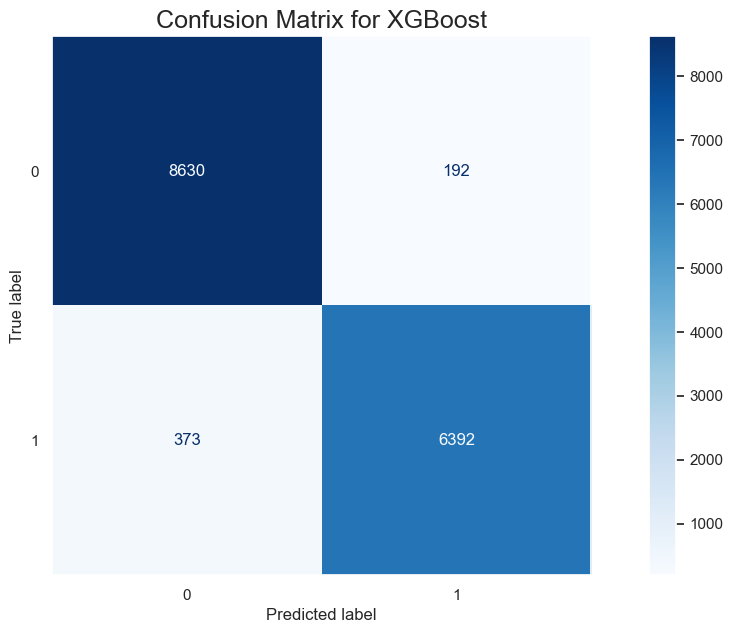

In [23]:
cm_xgb = confusion_matrix(test_y, yhat_xgb_ft, labels=clf_xgb_ft.classes_)
cm_xgb_disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=clf_xgb_ft.classes_)
cm_xgb_disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix for XGBoost', fontsize=18)
plt.grid(False)
plt.gca().set_facecolor('white')

plt.show()

## 9.2 LGBM

In [24]:
lgbm_tuned = lgbm.LGBMClassifier(**params_lgbm)

eval_lgbm = cross_validation(5, 'LGBM', lgbm_tuned, train_x, train_y)
eval_lgbm

0.9660667299802682

In [25]:
# model definition
clf_lgbm_ft = lgbm.LGBMClassifier(**params_lgbm)

# model training
clf_lgbm_ft.fit( train_x, train_y )

# model prediction - Check if the model perform well
yhat_lgbm_ft = clf_lgbm_ft.predict( test_x )

# Evaluation
precision_score(test_y, yhat_lgbm_ft, average='micro') 

0.965612369282094

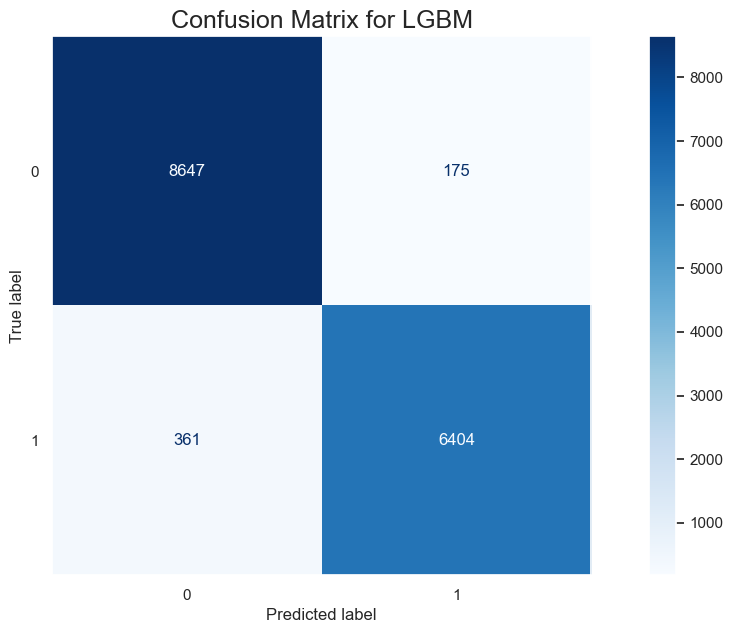

In [26]:
cm_lgbm = confusion_matrix(test_y, yhat_lgbm_ft,  labels = clf_lgbm_ft.classes_)
cm_lgbm_disp = ConfusionMatrixDisplay(confusion_matrix = cm_lgbm,
                                      display_labels = clf_lgbm_ft.classes_)

cm_lgbm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LGBM', fontsize=18)
plt.grid(False)
plt.gca().set_facecolor('white')

plt.show()

## Understanding the Model Calibration

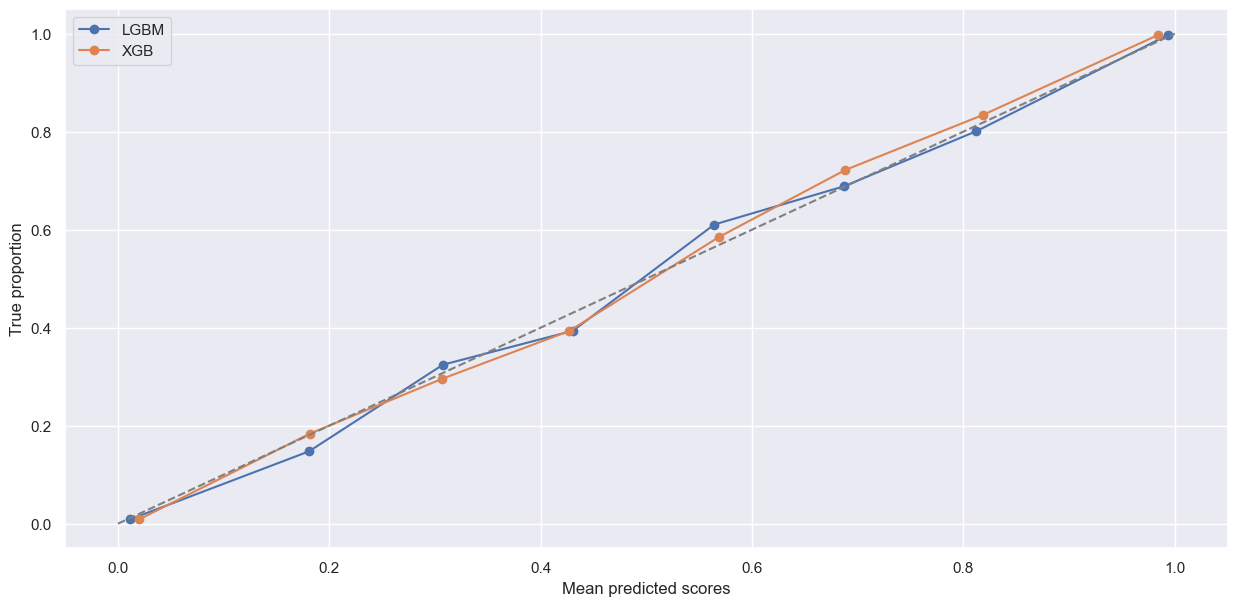

In [35]:
from sklearn.calibration import calibration_curve

fig, ax = plt.subplots()
models, names = [clf_lgbm_ft, clf_xgb_ft], ['LGBM', 'XGB']

for model, name in zip(models, names):
    y_probs = model.predict_proba(test_x)[:,1]
    proportion_true, prob_pred = calibration_curve(test_y, y_probs, n_bins=8)
    ax.plot(prob_pred, proportion_true, label=name, marker='o')

plt.plot([0,1], color='gray', linestyle='--')
plt.xlabel("Mean predicted scores")
plt.ylabel("True proportion")
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import brier_score_loss

for model, name in zip(models, names):
    y_probs = model.predict_proba(test_x)[:,1]
    print(f"BS = {round(brier_score_loss(test_y, y_probs),3)} ({name})")

BS = 0.026 (LGBM)
BS = 0.027 (XGB)


In [39]:
for model, name in zip(models, names):
    y_probs = model.predict(test_x)
    print(f"Precision_Micro = {round(precision_score(test_y, y_probs, average='micro'),3)} ({name})")

Precision_Micro = 0.966 (LGBM)
Precision_Micro = 0.964 (XGB)


### ECE: distância média (no sentido L1, e ponderada) de o quanto a curva de calibração se afasta da identidade.

In [41]:
def calib_curve_proportions(y_true, y_probs, n_bins=10, method='uniform'):
    from sklearn.calibration import calibration_curve
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # podemos agregar: calcule as médias de y=1 por chunk e calcule o score médio de cada chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    x, y = calibration['Average score'], calibration['Fraction of positives']
    p = predictions.groupby('bins').\
                   apply(lambda x: len(x)).\
                   values
    p = p/len(y_true)
    
    return x, y, p
def ece(y_true, y_probs, n_bins=10, method='uniform'):
    x, y, p = calib_curve_proportions(y_true, y_probs, n_bins=n_bins, method=method)
    return np.sum(p*np.abs(x - y))
for model, name in zip(models, names):
    y_probs = model.predict_proba(test_x)[:,1]
    print(f"ECE = {round(ece(test_y, y_probs, method='quantile'),3)} ({name})")

ECE = 0.003 (LGBM)
ECE = 0.011 (XGB)


## Last Training to save for deploy

In [80]:
df_last = df_raw.copy()

In [81]:
df_aux = test_prep(df_last)

In [83]:
X_training = df_aux.drop( ['satisfaction'], axis=1 )
y_training = df_aux['satisfaction'].copy()

In [ ]:
# Saving trained model to production
#joblib.dump(lgbm_tunado, 'lgbm.joblib')

## 9.3 ENSEMBLE

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
Ensemble = VotingClassifier(estimators = [('lgbm', clf_lgbm_one), ('xgb', clf_xgb_one)], 
                            voting='hard',
                            weights = [0.8, 0.5])

Ensemble.fit(X_training, y_training)

# 10. SUBMISSION

In [125]:
df_test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/InStyle_Net_Promoter_Score/data/test.csv')

In [126]:
df_test.shape

(25976, 23)

In [127]:
x_test = test_prep(df_test)

In [128]:
x_test.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom_,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
0,19556,0.507459,0.0,0.576923,0.689627,1.0,-0.513920,5,4,3,4,3,4,3,5,5,5,5,2,5,5,3.912023,3.784190
1,90035,0.507459,0.0,0.371795,0.689627,0.0,1.519940,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0.000000,0.000000
2,12360,0.492541,1.0,0.166667,0.689627,1.0,-0.489842,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0.000000,0.000000
3,77959,0.492541,0.0,0.474359,0.689627,0.0,1.906697,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0.000000,1.791759
4,36875,0.507459,0.0,0.538462,0.689627,1.0,0.255079,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0.000000,2.995732


In [129]:
chosen_model_index = 1
chosen_model = calibrated_models[chosen_model_index]

In [134]:
chosen_model

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.6313892474468165,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eta=0.019834339603301256,
                                               eval_metric=None,
                                               feature_types=None,
                                               gamma=0.3113641371820694,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.011,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=12, max_leaves=None,
                                               min_child_weight=2, missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=450, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, ...),
                       method='isotonic')

In [130]:
# Model Prediction
yhat_submission = chosen_model.predict(x_test)

In [131]:
x_test['satisfaction'] = yhat_submission

In [132]:
submission = x_test[['id','satisfaction']]

In [133]:
submission['satisfaction'].value_counts()

satisfaction
0    25976
Name: count, dtype: int64

In [110]:
submission.to_csv("submission_lgbm.csv", index=None, sep=',')

In [111]:
aux = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/InStyle_Net_Promoter_Score/notebook/sub_production.csv')
aux['satisfaction'].value_counts()

satisfaction
0.0    14903
1.0    11073
Name: count, dtype: int64

# 11. TO PRODUCTION

## 11.1 InStyle Class

In [ ]:

import json
import joblib
import inflection
import pandas   as pd
import numpy    as np

class instyle( object ):
    def __init__( self ):
        self.home_path     = 'C:/Users/perot/Documents/ds_repos/API e WebAPP/InStyle_API/src/features'
        self.fe_gender     = joblib.load( open( self.home_path + '/fe_gender.joblib', 'rb') )
        self.fe_tpurchase  = joblib.load( open( self.home_path + '/fe_tpurchase.joblib', 'rb') )
        self.mm_age        = joblib.load( open( self.home_path + '/mm_age.joblib', 'rb') )
        self.oe_ageg       = joblib.load( open( self.home_path + '/oe_ageg.joblib', 'rb'))
        self.oe_customer   = joblib.load( open( self.home_path + '/oe_customer.joblib', 'rb') )
        self.oe_distance   = joblib.load( open( self.home_path + '/oe_distance.joblib', 'rb') )
        self.oe_store      = joblib.load( open( self.home_path + '/oe_store.joblib', 'rb') )
        self.rs_stored     = joblib.load( open( self.home_path + '/rs_stored.joblib', 'rb') )
        
    def test_prep(self, df):
        ## Rename Columns
        cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase','Store size', 'Store distance', 'InStore wifi',
                    'Open/Close time convenient', 'Easy of online shopping', 'Store location', 'Toilet cleaning', 'Dressing room', 
                    'Waiting room','Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store', 'Purchase service', 
                    'Store Service', 'Cleanliness', 'Carrier delay in minutes', 'Delivery delay in minutes']

        snakecase = lambda x: inflection.underscore(x.replace(' ', '_'))
        cols_new = list( map( snakecase, cols_old ) )

        df.columns = cols_new

        # FEATURE ENGINEERING

        df['distancia'] = df['store_distance'].apply(lambda x: 'close' if x <= 2500 else 
                                                               'far' )



        df['age_group'] = df['age'].apply(lambda x: 'young' if x <= 18 else
                                                    'adult' if ((x > 18) and (x <= 60)) else
                                                    'elderly')

        # TRANSFORMERS
        # gender
        df['gender'] = df['gender'].map(self.fe_gender)

        # type_of_purchase
        df['type_of_purchase'] = df['type_of_purchase'].map( self.fe_tpurchase )

        # distance
        df['distancia'] = self.oe_distance.transform(df[['distancia']].values)

        # distance
        df['age_group'] = self.oe_ageg.transform(df[['age_group']].values)

        # distance
        df['customer_type'] = self.oe_customer.transform(df[['customer_type']].values)

        # Store Size
        df['store_size'] = self.oe_store.transform(df[['store_size']].values)

        # REESCALING

        # age
        df['age'] = self.mm_age.transform(df[['age']].values)

        # Store Distance
        df['store_distance'] = self.rs_stored.transform(df[['store_distance']].values)

        # LOG TRANSFORMATION 

        # carrier_delay_in_minutes
        df['carrier_delay_in_minutes'] = df['carrier_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x) 

        # delivery_delay_in_minutes
        df['delivery_delay_in_minutes'] = df['delivery_delay_in_minutes'].apply(lambda x: np.log(x) if x > 0 else x) 

        return(df)
    
    def get_prediction (self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['satisfaction'] =  pred 
        
        return original_data.to_json( orient='records', date_format='iso' )  

In [ ]:
import joblib
import pandas as pd
import os
from flask                           import Flask, request, Response
from instyle.instyle import instyle

# logading model
model = joblib.load( open('src/models/lgbm.joblib', 'rb') )
                          
# initialize API
app = Flask( __name__ )

@app.route( '/instyle/predict', methods=['POST'] )
def instyle_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Instyle Class
        pipeline = instyle()

        # Data Preparation
        df1 = pipeline.test_prep( test_raw )
                              
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df1 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run('0.0.0.0')
    #port = os.environ.get('PORT', 5000)
    #app.run( host='0.0.0.0', port=port )

# API CALL

In [ ]:
import requests
import pandas as pd

In [ ]:
test = pd.read_csv('C:/Users/perot/Documents/ds_repos/projects/InStyle_Net_Promoter_Score/data/test.csv')

In [ ]:
teste = test.head(10)

In [ ]:
data = json.dumps( test.to_dict( orient='records'))

In [ ]:
# API Call
url = 'http://127.0.0.1:5000/instyle/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data , headers=header )
print( 'Stadus Code{}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1.head()

In [ ]:
submission = d1[['id','satisfaction']]

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=None, sep=',')